In [194]:
# импортируем библиотеки необходимые для дальнейшего анализа
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt
import plotly.express as px

# модуль поможет убрать предупреждения, которые могут выкидывать некоторые методы
import warnings
warnings.filterwarnings("ignore")

# параметры для будущих графиков
sns.set(rc={'figure.figsize':(14,8)}, style="whitegrid", font='sans-serif')

### В этом проекте проведу анализ данных по факту пользовательских покупок, попутно отвечая на следующие вопросы:
1. Сколько у нас пользователей, которые совершили покупку только один раз? 
2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 
3. По каждому товару определить, в какой день недели товар чаще всего покупали
4. Используя pandas, проведём когортный анализ пользователей. В период с января по декабрь выявим когорту с самым высоким retention на 3й месяц.
5. Проведём RFM анализ пользователей.

### 1. Загрузим данные, проведём предварительный анализ, ответим на вопрос, что будем считать за свершившуюся покупку

**Таблица №1**

In [3]:
# таблица с уникальными идентификаторами пользователей
uniq_customer_id = pd.read_csv('C:/Users/MAGICAL/Desktop/Python/df/olist_customers_dataset.csv')

**расшифровка названий колонок в данных**

customer_id — позаказный идентификатор пользователя

customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)

customer_zip_code_prefix —  почтовый индекс пользователя

customer_city —  город доставки пользователя

customer_state —  штат доставки пользователя

In [4]:
uniq_customer_id.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [5]:
# общая информация
uniq_customer_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [6]:
# проверка на количество Na значении
uniq_customer_id.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [7]:
# проверим данные на дубликаты
duplicateRows = uniq_customer_id[uniq_customer_id.duplicated()]
duplicateRows

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state


**Таблица №2**

In [8]:
# товарные позиции, входящие в заказы
product_id_data = pd.read_csv('C:/Users/MAGICAL/Desktop/Python/df/olist_order_items_dataset.csv')

**расшифровка названий колонок в данных**

order_id —  уникальный идентификатор заказа (номер чека)

order_item_id —  идентификатор товара внутри одного заказа

product_id —  ид товара (аналог штрихкода)

seller_id — ид производителя товара

shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

price —  цена за единицу товара

freight_value —  вес товара

In [13]:
product_id_data.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [12]:
# общая информация
product_id_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [11]:
# проверка на количество Na значении
product_id_data.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [10]:
# проверим данные на дубликаты
duplicateRows = product_id_data[product_id_data.duplicated()]
duplicateRows

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value


**Таблица №3**

In [15]:
# таблица заказов
data_orders = pd.read_csv('C:/Users/MAGICAL/Desktop/Python/df/olist_orders_dataset.csv', parse_dates=['order_approved_at', 'order_purchase_timestamp', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'])

**расшифровка названий колонок в данных**

order_id —  уникальный идентификатор заказа (номер чека)

customer_id —  позаказный идентификатор пользователя

order_status —  статус заказа

order_purchase_timestamp —  время создания заказа

order_approved_at —  время подтверждения оплаты заказа

order_delivered_carrier_date —  время передачи заказа в логистическую службу

order_delivered_customer_date —  время доставки заказа

order_estimated_delivery_date —  обещанная дата доставки

In [16]:
data_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [17]:
data_orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [21]:
# общая информация
data_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [18]:
# проверка на количество Na значении
data_orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

В данной таблице имеются пропуски в следующих колонках:

order_approved_at —  время подтверждения оплаты заказа

order_delivered_carrier_date —  время передачи заказа в логистическую службу

order_delivered_customer_date —  время доставки заказа

In [21]:
# проверим данные на дубликаты
duplicateRows = data_orders[product_id_data.duplicated()]
duplicateRows

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date


### Для дальнейшего анализа необходимо объдинить в единую таблицу наши данные

In [23]:
# объединим данные двух таблиц по колонке order_id, методом = inner
product_orders = product_id_data.merge(data_orders, on='order_id', how='inner')

In [210]:
# по такому же принципу объединим две таблицы, но уже по колонке customer id
id_orders_product = uniq_customer_id.merge(product_orders, on='customer_id', how='inner')

In [25]:
id_orders_product.shape

(112650, 18)

In [26]:
id_orders_product.isna().sum()

customer_id                         0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_id                            0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1194
order_delivered_customer_date    2454
order_estimated_delivery_date       0
dtype: int64

In [28]:
# заменим пропущенные значения на 0, в дальнейшем будем это учитывать
id_orders_product = id_orders_product.fillna(0)

Факт покупки будем считать, что статус заказа не равен = canceled, имеются сведения о времени доставки заказа, а также есть время подтверждения оплаты заказа

In [29]:
# факт покупки
data_fact_of_purchase = id_orders_product.query("order_status != 'canceled' and order_delivered_customer_date != 0 and order_approved_at !=0")

In [32]:
data_fact_of_purchase.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [30]:
data_fact_of_purchase.shape

(110174, 18)

In [33]:
# 90537 пользователей совершили покупку 1 товара
data_fact_of_purchase.groupby('customer_unique_id', as_index=False) \
                     .agg(number_orders=('order_id', 'nunique')) \
                     .query('number_orders == 1').count()

customer_unique_id    90537
number_orders         90537
dtype: int64

In [34]:
# не доставленные заказы по разным причинам
id_orders_product.query("order_status != 'delivered'") \
                 .groupby('order_status', as_index=False) \
                 .agg(reason_not_delivery=('order_id', 'count'))

,order_status,reason_not_delivery
0,approved,3
1,canceled,542
2,invoiced,359
3,processing,357
4,shipped,1185
5,unavailable,7


In [36]:
# вытащим из даты определенный день недели, для определения дня самых частых покупок
id_orders_product['name_week_buy_product'] = id_orders_product.order_purchase_timestamp.dt.day_name()

In [37]:
id_orders_product.groupby(['product_id', 'name_week_buy_product'], as_index=False) \
                 .agg({'order_id' : 'count'}) \
                 .sort_values('order_id', ascending=False)

,product_id,name_week_buy_product,order_id
15902,422879e10f46682990de24d770e7f83d,Wednesday,93
36513,99a4788cb24856965c36a24e339b6058,Monday,92
41045,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
41041,aca2eb7d00ea1a7b8ebd4e68314663af,Friday,87
41046,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,85
...,...,...,...
24013,642369377615febc7fa89e4c8df5110e,Thursday,1
24018,642a40d4d73b4b2604968937de13634a,Sunday,1
24022,642e125cbc752b4eeb8faf442319c39f,Thursday,1
24025,64315bd8c0c47303179dd2e25b579d00,Saturday,1


### Предобработаем данные для когортного анализа

In [38]:
# функция возвращающая из даты год и месяц
def getting_months(m):
    return dt.datetime(m.year, m.month,1)

In [42]:
id_orders_cohort = id_orders_product[['customer_id', 'customer_unique_id', 'order_id', 'order_item_id', 'product_id', 'price', 'order_status', 'order_purchase_timestamp']]

In [43]:
# при помощи ранее заданной функции добавим колонку с месяцем покупки
id_orders_cohort['month_purchase'] = id_orders_cohort['order_purchase_timestamp'].apply(getting_months)

In [46]:
# когорты будем отбирать в промежутке с января 2017 г. по декабрь 2017
id_orders_product_cohort = id_orders_cohort.query("'2017-01' <= month_purchase <= '2017-12'")

In [47]:
id_orders_product_cohort.head()

,customer_id,customer_unique_id,order_id,order_item_id,product_id,price,order_status,order_purchase_timestamp,month_purchase
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,1,a9516a079e37a9c9c36b9b78b10169e8,124.99,delivered,2017-05-16 15:05:35,2017-05-01
5,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,5741ea1f91b5fbab2bd2dc653a5b5099,1,0be701e03657109a8a4d5168122777fb,259.90,delivered,2017-09-14 18:14:31,2017-09-01
7,5e274e7a0c3809e14aba7ad5aae0d407,57b2a98a409812fe9618067b6b8ebe4f,1093c8304c7a003280dd34598194913d,1,124f74f703e88efe001a10bfa718b6ff,19.90,delivered,2017-11-16 19:29:02,2017-11-01
10,9fb35e4ed6f0a14a4977cd9aea4042bb,2a7745e1ed516b289ed9b29c7d0539a5,8428e578bb1cf839ae26a6b7615502b9,1,6b874ff4c71d18e91079b40396bf176a,25.30,delivered,2017-11-27 17:23:20,2017-11-01
12,b2d1536598b73a9abd18e0d75d92f0a3,918dc87cd72cd9f6ed4bd442ed785235,83d8f70418eefd96f37b483dff430305,1,3fc00af0f0a8d4ac2933d3900416c977,99.00,delivered,2017-09-09 09:54:57,2017-09-01


In [48]:
# определим колонку с первым месяцем покупки пользователя
id_orders_product_cohort['Cohort_Month'] =  id_orders_product_cohort.groupby('customer_unique_id')['month_purchase'].transform('min')

In [49]:
id_orders_product_cohort.head()

,customer_id,customer_unique_id,order_id,order_item_id,product_id,price,order_status,order_purchase_timestamp,month_purchase,Cohort_Month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,1,a9516a079e37a9c9c36b9b78b10169e8,124.99,delivered,2017-05-16 15:05:35,2017-05-01,2017-05-01
5,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,5741ea1f91b5fbab2bd2dc653a5b5099,1,0be701e03657109a8a4d5168122777fb,259.90,delivered,2017-09-14 18:14:31,2017-09-01,2017-09-01
7,5e274e7a0c3809e14aba7ad5aae0d407,57b2a98a409812fe9618067b6b8ebe4f,1093c8304c7a003280dd34598194913d,1,124f74f703e88efe001a10bfa718b6ff,19.90,delivered,2017-11-16 19:29:02,2017-11-01,2017-11-01
10,9fb35e4ed6f0a14a4977cd9aea4042bb,2a7745e1ed516b289ed9b29c7d0539a5,8428e578bb1cf839ae26a6b7615502b9,1,6b874ff4c71d18e91079b40396bf176a,25.30,delivered,2017-11-27 17:23:20,2017-11-01,2017-11-01
12,b2d1536598b73a9abd18e0d75d92f0a3,918dc87cd72cd9f6ed4bd442ed785235,83d8f70418eefd96f37b483dff430305,1,3fc00af0f0a8d4ac2933d3900416c977,99.00,delivered,2017-09-09 09:54:57,2017-09-01,2017-09-01


In [50]:
# функция для конвертирования серии, разбивающей дату на составные части. Возвращает функция день, месяц и год
def get_date_elements(df, column):
    day = df[column].dt.day
    month = df[column].dt.month
    year = df[column].dt.year
    return day, month, year 

In [51]:
# серия из месяца и года первой покупки каждого пользователя
_,Invoiceofmonth,Invoiceofyear =  get_date_elements(id_orders_product_cohort,'month_purchase')

In [54]:
# серия из месяца и года когорт
_,Cohortofmonth,Cohortofyear =  get_date_elements(id_orders_product_cohort,'Cohort_Month')

In [55]:
# проиндексируем когорты, после чего отсортируем месяц и год первого посещения пользователя
yeardifference = Invoiceofyear -Cohortofyear
monthdifference = Invoiceofmonth - Cohortofmonth
id_orders_product_cohort['Cohort_Index'] = yeardifference*12+monthdifference+1
cohort_data = id_orders_product_cohort.groupby(['Cohort_Month','Cohort_Index'])['customer_unique_id'].apply(pd.Series.nunique).reset_index()


In [56]:
cohort_data.head()

,Cohort_Month,Cohort_Index,customer_unique_id
0,2017-01-01,1,755
1,2017-01-01,2,3
2,2017-01-01,3,2
3,2017-01-01,4,1
4,2017-01-01,5,3


In [59]:
# создадим сводную таблицу для когортного анализа
cohort_table = cohort_data.pivot(index='Cohort_Month', columns=['Cohort_Index'],values='customer_unique_id')

# изменин числовые значения месяца когорт, на буквенные
cohort_table.index = cohort_table.index.strftime('%B %Y')

In [60]:
cohort_table

Cohort_Index,1,2,3,4,5,6,7,8,9,10,11,12
Cohort_Month,,,,,,,,,,,,
January 2017,755.0,3.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,NaN,3.0,1.0
February 2017,1705.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,2.0,3.0,2.0,NaN
March 2017,2595.0,13.0,9.0,10.0,9.0,4.0,4.0,8.0,9.0,2.0,NaN,NaN
April 2017,2340.0,14.0,5.0,4.0,8.0,6.0,8.0,7.0,7.0,NaN,NaN,NaN
May 2017,3560.0,17.0,17.0,14.0,11.0,12.0,15.0,5.0,NaN,NaN,NaN,NaN
June 2017,3114.0,15.0,11.0,12.0,8.0,12.0,12.0,NaN,NaN,NaN,NaN,NaN
July 2017,3844.0,20.0,14.0,9.0,11.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN
August 2017,4149.0,28.0,14.0,11.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
September 2017,4091.0,28.0,22.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
# Переведём значение в процентное соотношение
new_cohort_table = cohort_table.divide(cohort_table.iloc[:,0],axis=0)
new_cohort_table

Cohort_Index,1,2,3,4,5,6,7,8,9,10,11,12
Cohort_Month,,,,,,,,,,,,
January 2017,1.0,0.003974,0.002649,0.001325,0.003974,0.001325,0.003974,0.001325,0.001325,NaN,0.003974,0.001325
February 2017,1.0,0.002346,0.002933,0.001173,0.004106,0.001173,0.002346,0.001760,0.001173,0.001760,0.001173,NaN
March 2017,1.0,0.005010,0.003468,0.003854,0.003468,0.001541,0.001541,0.003083,0.003468,0.000771,NaN,NaN
April 2017,1.0,0.005983,0.002137,0.001709,0.003419,0.002564,0.003419,0.002991,0.002991,NaN,NaN,NaN
May 2017,1.0,0.004775,0.004775,0.003933,0.003090,0.003371,0.004213,0.001404,NaN,NaN,NaN,NaN
June 2017,1.0,0.004817,0.003532,0.003854,0.002569,0.003854,0.003854,NaN,NaN,NaN,NaN,NaN
July 2017,1.0,0.005203,0.003642,0.002341,0.002862,0.002081,NaN,NaN,NaN,NaN,NaN,NaN
August 2017,1.0,0.006749,0.003374,0.002651,0.003615,NaN,NaN,NaN,NaN,NaN,NaN,NaN
September 2017,1.0,0.006844,0.005378,0.002933,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: title={'center': 'Когортный анализ пользователей'}, xlabel='Cohort_Index', ylabel='Cohort_Month'>

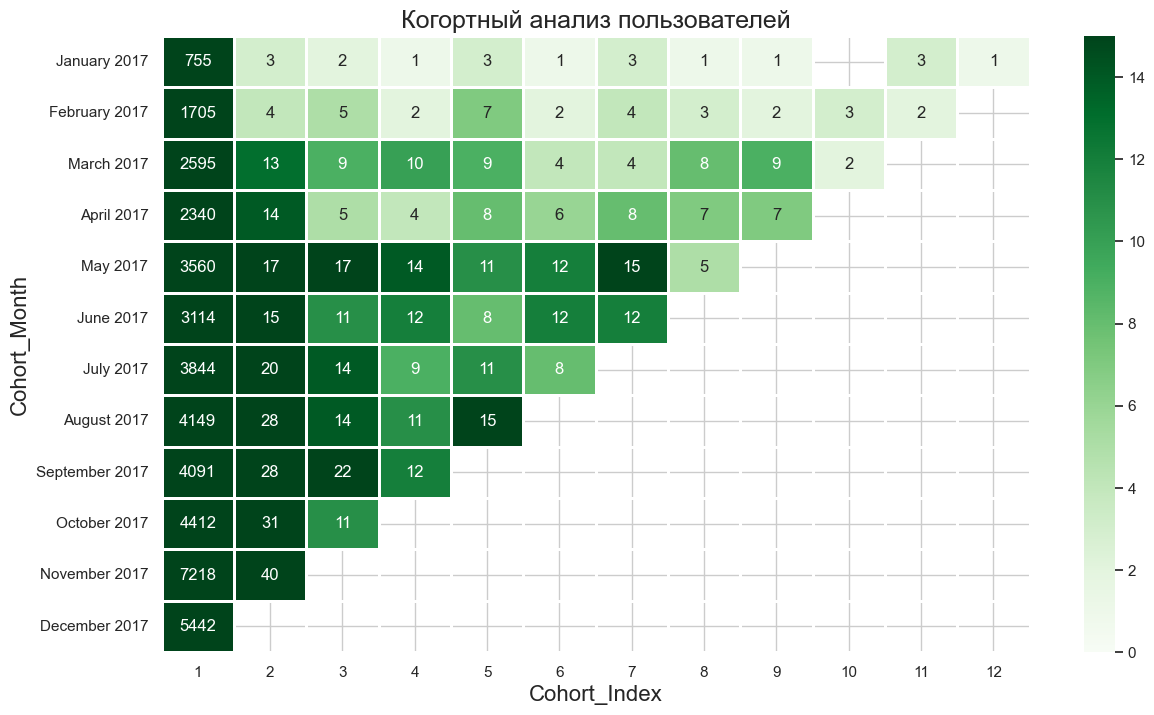

In [195]:
# построим график со следующими параметрами
plt.rcParams['axes.titlesize'] = 18
plt.xlabel('xlabel', fontsize=16)
plt.ylabel('ylabel', fontsize=16)
plt.title('Когортный анализ пользователей')
sns.set(font='sans-serif')
sns.heatmap(cohort_table, annot=True, fmt = '.0f', vmin=0, vmax=15, cmap='Greens', linewidths = 1, linecolor = "white")

<Axes: title={'center': 'Когортный анализ пользователей'}, xlabel='Cohort_Index', ylabel='Cohort_Month'>

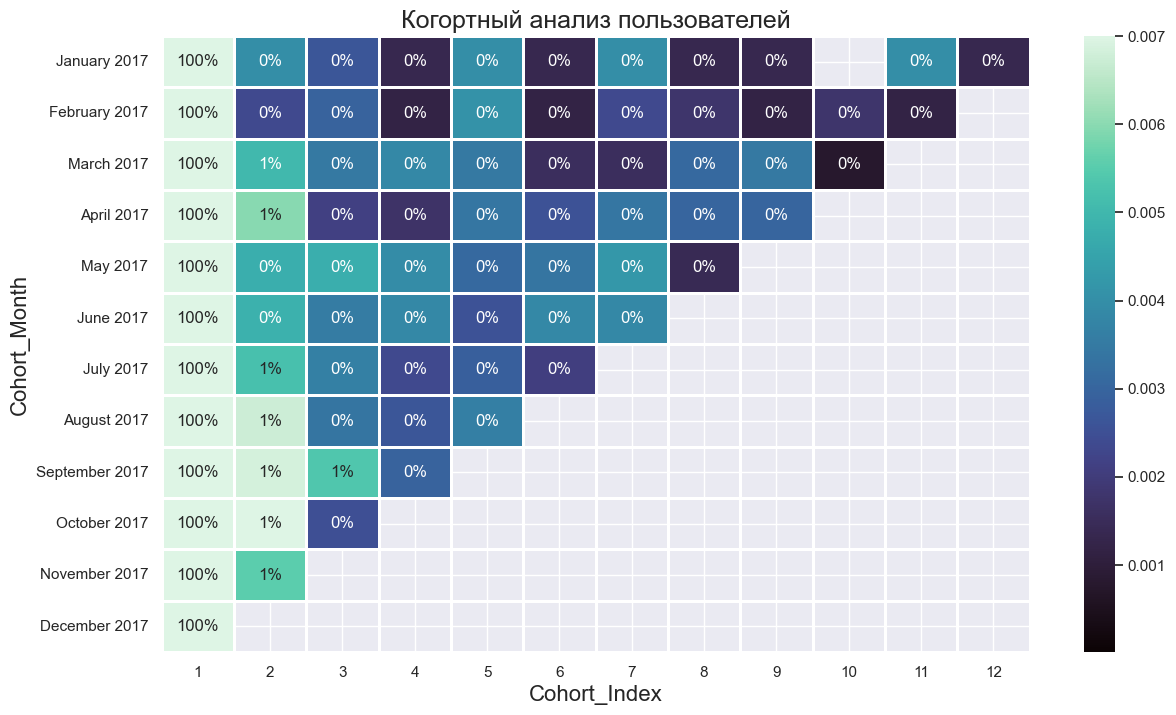

In [196]:
# построим график в процентном отображении
plt.rcParams['axes.titlesize'] = 18
plt.xlabel('xlabel', fontsize=16)
plt.ylabel('ylabel', fontsize=16)
plt.title('Когортный анализ пользователей')
sns.set(font='sans-serif')
sns.heatmap(new_cohort_table, annot=True, fmt = '.0%', vmin=0.00001, vmax=0.007, cmap='mako', linewidths = 1, linecolor = "white")

### В данном случае не сложно догадаться, что на 3 месяц когорта пришедшая в мае 2017 г. имела наибольший процент возврата, в целом, на второй месяц процент возврата составляет не более 1%, что очень мало, почти 99% пользователей перестают преобретать товар

### Заключительная стадия: RFM анализ
создадим таблицу, где будут хранится данные об уникальных id пользователей, общая сумма покупок, колияества покупок, дата совершения последней покупки, количество дней с момента последней покупки

In [138]:
# создадим таблицу 
df_rfm = id_orders_product.groupby('customer_unique_id').agg(
    purchase_sum = ('price', 'sum'),
    purchase_amount = ('price', 'count'),
    last_purchase = ('order_purchase_timestamp', 'last'),
).reset_index()

In [139]:
# количество дней с последней покупки
df_rfm['days_since_last_purchase'] = (max(id_orders_product['order_purchase_timestamp']) - df_rfm['last_purchase']).dt.days

In [140]:
df_rfm.head()

,customer_unique_id,purchase_sum,purchase_amount,last_purchase,days_since_last_purchase
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90,1,2018-05-10 10:56:27,115
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,1,2018-05-07 11:11:27,118
2,0000f46a3911fa3c0805444483337064,69.00,1,2017-03-10 21:05:03,541
3,0000f6ccb0745a6a4b88665a16c9f078,25.99,1,2017-10-12 20:29:41,325
4,0004aac84e0df4da2b147fca70cf8255,180.00,1,2017-11-14 19:45:42,292


In [141]:
# поедлим наши данные на диапазоны при помощи квантилей
quintiles = df_rfm[['last_purchase', 'purchase_amount', 'purchase_sum']].quantile([.2, .5, .8]).to_dict()
quintiles

{'last_purchase': {0.2: Timestamp('2017-08-09 12:19:56.800000'),
  0.5: Timestamp('2018-01-20 21:03:27'),
  0.8: Timestamp('2018-05-27 11:08:40')},
 'purchase_amount': {0.2: 1.0, 0.5: 1.0, 0.8: 1.0},
 'purchase_sum': {0.2: 39.9, 0.5: 89.9, 0.8: 179.9}}

In [142]:
# функция для ранжирования наших пользователей от 1 до 5
def r_score(x):
    if x <= quintiles['last_purchase'][.2]:
        return 3
    elif x <= quintiles['last_purchase'][.5]:
        return 2
    else:
        return 1

def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.5]:
        return 2
    else:
        return 3

In [143]:
# при помощи нашей функции поделим пользователей на сегменты
df_rfm['R'] = df_rfm['last_purchase'].apply(lambda x: r_score(x))
df_rfm['F'] = df_rfm['purchase_amount'].apply(lambda x: fm_score(x, 'purchase_amount'))
df_rfm['M'] = df_rfm['purchase_sum'].apply(lambda x: fm_score(x, 'purchase_sum'))

In [144]:
# итоговая колонка анализа, отображающая итоговый балл пользователя
df_rfm.R = df_rfm.R.astype('str')
df_rfm.F = df_rfm.F.astype('str')
df_rfm.M = df_rfm.M.astype('str')

df_rfm['RFMScore'] = df_rfm.R + df_rfm.F + df_rfm.M

### Описание значений RFM
Recency (R) — давность (как давно клиент что-то у вас покупали);
Frequency(F) — частота (как часто клиенты совершают покупки);
Monetary(M) — деньги (общая сумма покупок).

**По категории (recency):**
1 — давние клиенты;
2 — относительно недавние клиенты;
3 — недавние клиенты.

**По категории (frequency):**
1 — покупает очень редко (единичные заказы);
2 — покупает нечасто;
3 — покупает часто.

**По категории (monetary):**
1 — маленькая сумма;
2 — средняя сумма;
3 — большая сумма.

### Итоговые сегменты:
1. **Самые активные пользователи**: последняя покупка недавно, много товаров, большая сумма трат
2. **Лояльные покупатели**: регулярно совершают покупки
3. **Потенциальные лояльные клиенты**: средняя частота совершения покупок
4. **Недавние клиенты**: последняя покупка была не так давно, покупает не часто
5. **Многообещающие клиенты**: покупали недавно, но не на большую сумму
6. **Клиенты требующие внимания**: давность, частота, стоимость покупки выше среднего, но последняя покупка была давно
7. **Простаивающие клиенты** частота, стоимость, давность покупок ниже среднего
8. **Клиенты в зоне риска**: покупал часто, но давно
9. **Клиенты утратившие интерес**: часто покупали, но давно не возвращались.
10. **Почти потерянные клиенты**: последняя покупка была давно, с небольшим количеством товаров.

In [177]:
segt_map = {
    r'[1-2][1-2]': 'Почти потерянные клиенты',
    r'[1-2][3-4]': 'Клиенты в зоне риска',
    r'[1-2]5': 'Клиенты утратившие интерес',
    r'3[1-2]': 'Простаивающие клиенты',
    r'33': 'Клиенты требующие внимания',
    r'[3-4][4-5]': 'Лояльные покупателиs',
    r'41': 'Многообещающие клиенты',
    r'51': 'Недавние клиенты',
    r'[4-5][2-3]': 'Потенциальные лояльные клиенты',
    r'5[4-5]': 'Самые активные пользователи'
}

df_rfm['Segment'] = df_rfm['R'].map(str) + df_rfm['F'].map(str)
df_rfm['Segment'] = df_rfm['Segment'].replace(segt_map, regex=True)
df_rfm

,customer_unique_id,purchase_sum,purchase_amount,last_purchase,days_since_last_purchase,R,F,M,RFMScore,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90,1,2018-05-10 10:56:27,115,1,1,3,113,Почти потерянные клиенты
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,1,2018-05-07 11:11:27,118,1,1,1,111,Почти потерянные клиенты
2,0000f46a3911fa3c0805444483337064,69.00,1,2017-03-10 21:05:03,541,3,1,2,312,Простаивающие клиенты
3,0000f6ccb0745a6a4b88665a16c9f078,25.99,1,2017-10-12 20:29:41,325,2,1,1,211,Почти потерянные клиенты
4,0004aac84e0df4da2b147fca70cf8255,180.00,1,2017-11-14 19:45:42,292,2,1,3,213,Почти потерянные клиенты
...,...,...,...,...,...,...,...,...,...,...
95415,fffcf5a5ff07b0908bd4e2dbc735a684,1570.00,2,2017-06-08 21:00:36,451,3,3,3,333,Клиенты требующие внимания
95416,fffea47cd6d3cc0a88bd621562a9d061,64.89,1,2017-12-10 20:07:56,266,2,1,2,212,Почти потерянные клиенты
95417,ffff371b4d645b6ecea244b27531430a,89.90,1,2017-02-07 15:49:16,572,3,1,2,312,Простаивающие клиенты
95418,ffff5962728ec6157033ef9805bacc48,115.00,1,2018-05-02 15:17:41,123,1,1,3,113,Почти потерянные клиенты


In [184]:
# количество пользователей по категориям
df_rfm.groupby('Segment', as_index=False) \
      .agg(column_segment = ('Segment', 'count')) \
      .sort_values('column_segment', ascending=False)

,Segment,column_segment
2,Почти потерянные клиенты,66905
3,Простаивающие клиенты,16646
0,Клиенты в зоне риска,9431
1,Клиенты требующие внимания,2438


In [204]:
data_plot = df_rfm.groupby('Segment') \
                  .agg(all_users = ('RFMScore', 'count')).reset_index()
data_plot

,Segment,all_users
0,Клиенты в зоне риска,9431
1,Клиенты требующие внимания,2438
2,Почти потерянные клиенты,66905
3,Простаивающие клиенты,16646


### Ообразим получившиеся результаты на графиках

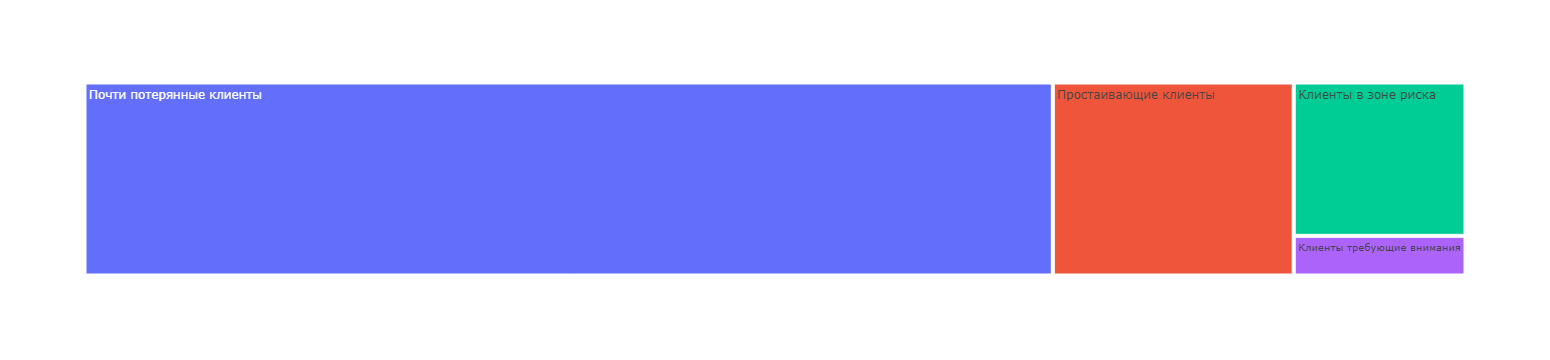

In [208]:
# treemap
px.treemap(data_plot, path=['Segment'], values='all_users')

<Axes: xlabel='Segment', ylabel='all_users'>

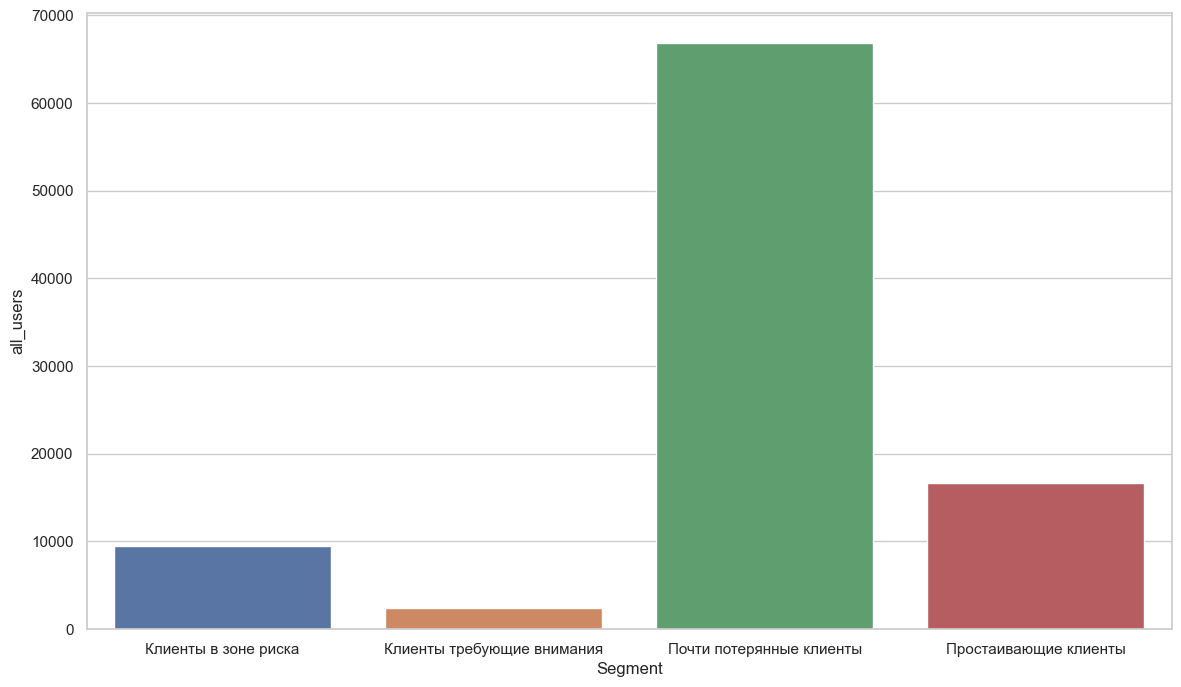

In [209]:
# barplot
sns.set(rc={'figure.figsize':(14,8)}, style="whitegrid", font='sans-serif')
sns.barplot(x='Segment', y='all_users', data=data_plot)